In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

2023-01-19 13:16:20.083866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 13:16:20.150790: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 13:16:20.467756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mehathab/miniconda3/envs/corn_dev/lib/python3.8/site-packages/cv2/../../lib64::/home/mehatha

In [2]:
dataset_directory = 'Dataset/'
train_directory = dataset_directory+'train/'
valid_directory = dataset_directory+'valid/'

In [3]:
def colorspace(img):
    image = img.astype("uint8")    
    image_converted = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    image_preprocessed = preprocess_input(image_converted)
    
    return image_preprocessed.astype('float32')

In [4]:
training = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.2,
    vertical_flip=True,
    width_shift_range=0.2,
    rotation_range=20,
    preprocessing_function=colorspace,
    fill_mode='nearest',
)

validation = ImageDataGenerator(
    preprocessing_function=colorspace
)

In [5]:
batch_size = 64
epochs = 100

In [6]:
training_data = training.flow_from_directory(train_directory,
                                            target_size=(299,299),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True,
                                           )

validating_data = validation.flow_from_directory(valid_directory,
                                               target_size=(299,299),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,)

Found 30000 images belonging to 3 classes.
Found 3545 images belonging to 3 classes.


In [7]:
training_image , label = training_data.next()
len(training_data) * batch_size

30016

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


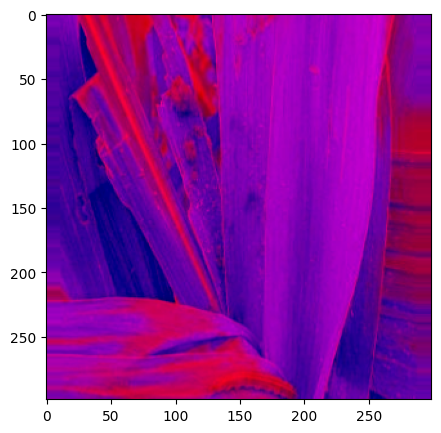

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


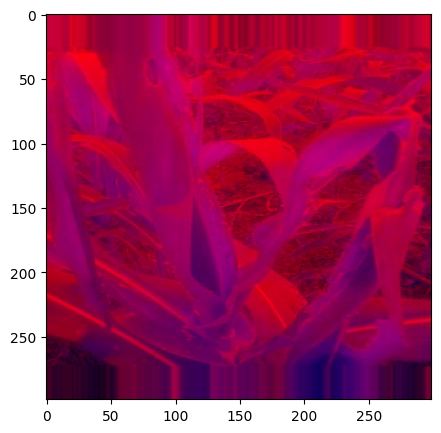

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


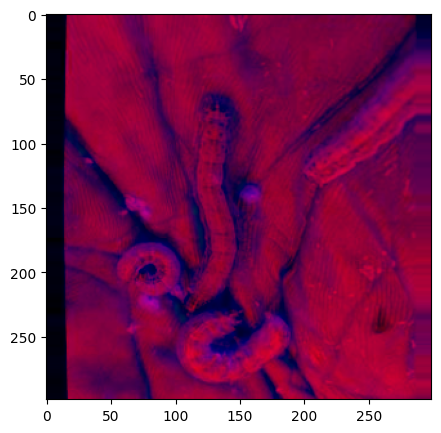

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


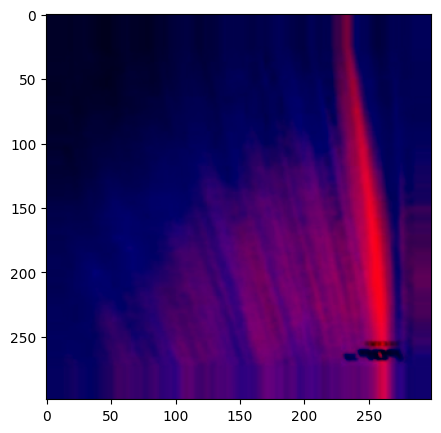

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


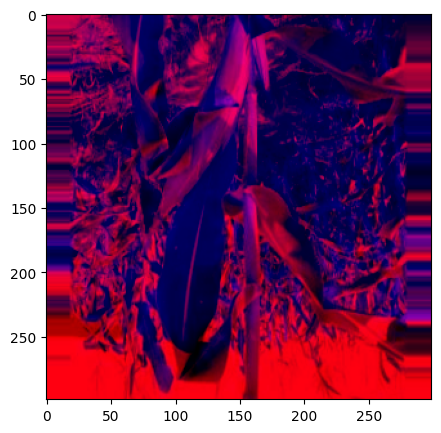

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


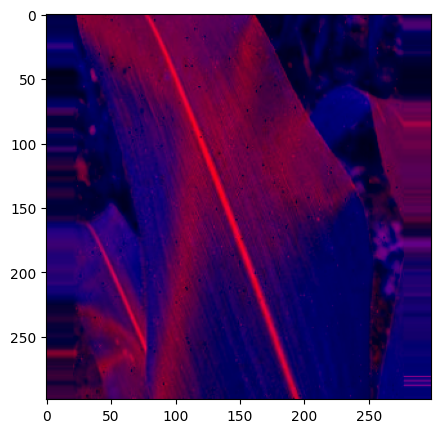

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


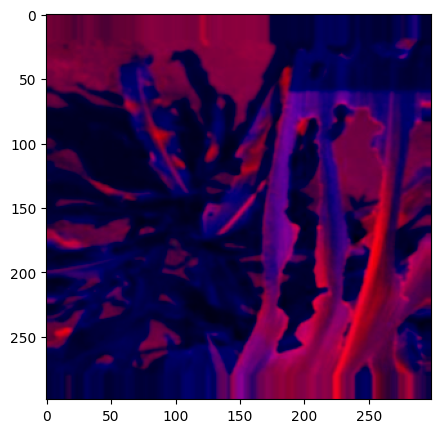

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


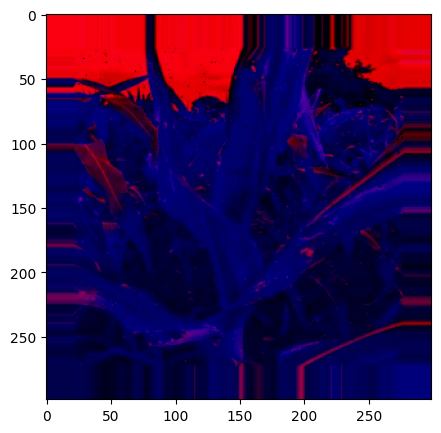

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


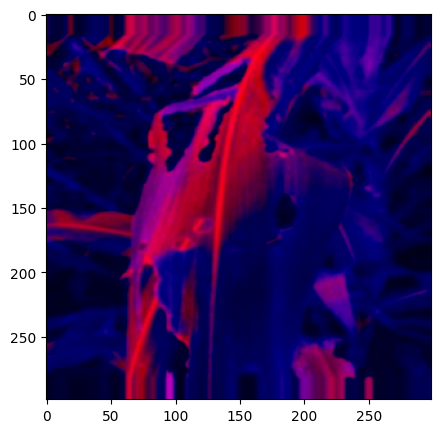

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


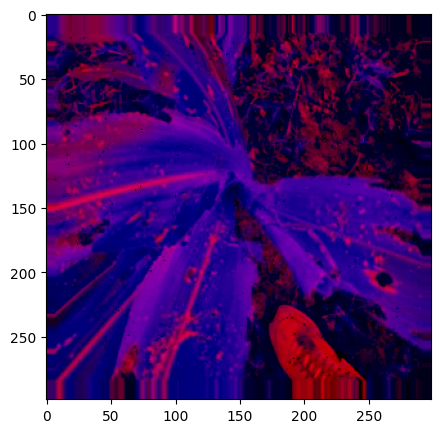

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


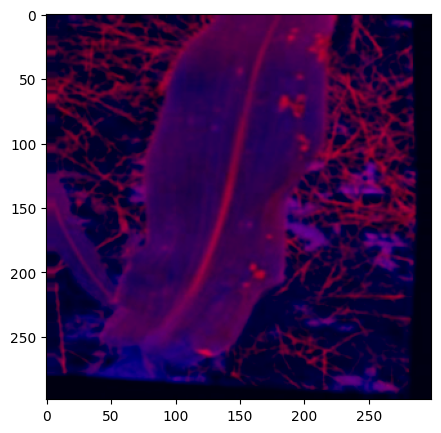

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


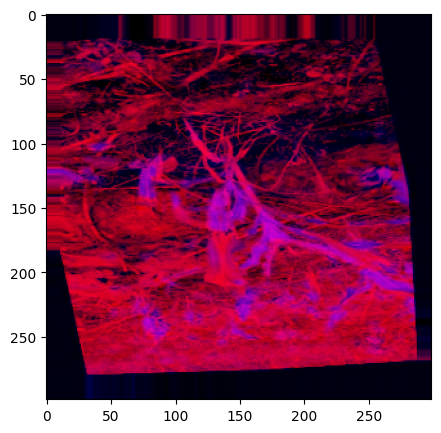

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


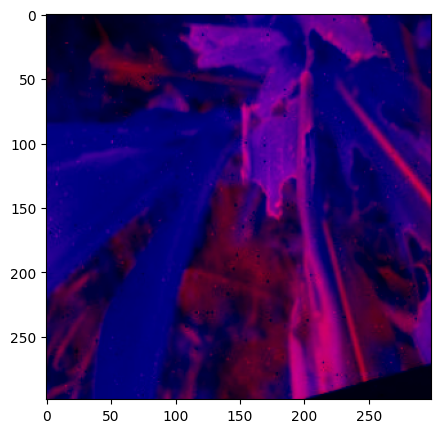

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


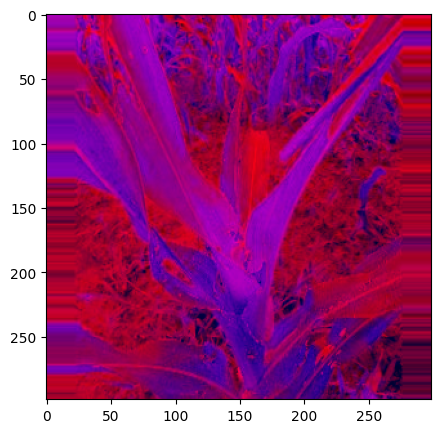

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


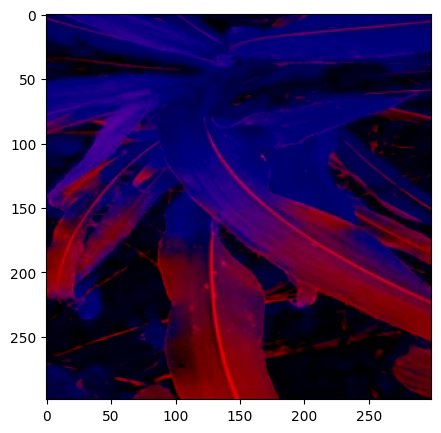

In [8]:
def plot_img(img_arr, label):    
    for i in range(len(img_arr)):
        img = img_arr[i]
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()

plot_img(training_image[:15],label[:15])

In [9]:
training_classes_dictionary = training_data.class_indices
classifications = list(training_classes_dictionary.keys())
classifications

['Healthy', 'Non Sprayable', 'Sprayable']

In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

In [11]:
base_model = InceptionResNetV2(input_shape=(299,299,3),include_top=False,weights='imagenet',classifier_activation=None)

2023-01-19 13:16:23.318872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:16:23.322084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:16:23.322611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:16:23.323460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [12]:
print(len(base_model.layers))
for i in base_model.layers[:-101]:
    i.trainable = False
# base_model.trainable = False
base_model.summary()

780
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                           

 batch_normalization_5 (BatchNo  (None, 35, 35, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 35, 35, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 35, 35, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 35, 35, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 35, 35, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 35, 35, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 35, 35, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 35, 35, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 17, 17, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 17, 17, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 17, 17, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 17, 17, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 17, 17, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 17, 17, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 17, 17, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 17, 17, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 17, 17, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 17, 17, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 17, 17, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 17, 17, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 17, 17, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 8, 8, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 8, 8, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 8, 8, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 8, 8, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
Total params: 54,336,736
Trainable params: 16,337,696
Non-trainable params: 37,999,040
__________________________________________________________________________________________________


In [13]:
flatten = GlobalAveragePooling2D()(base_model.output)

fc1 = Dense(units=4096, activation='relu')(flatten)
dropout = Dropout(0.6)(fc1)
batch1 = BatchNormalization()(dropout)
fc2 = Dense(units=1024, activation='relu')(batch1)
dropout = Dropout(0.6)(fc2)
batch2 = BatchNormalization()(dropout)


predictions = Dense(units=3, activation='softmax')(batch2)

In [14]:
model = Model(base_model.input, predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 35, 35, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 35, 35, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 35, 35, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 35, 35, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 35, 35, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 35, 35, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 35, 35, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 35, 35, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 17, 17, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 17, 17, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 17, 17, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 17, 17, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 17, 17, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 17, 17, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 17, 17, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 17, 17, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 17, 17, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 17, 17, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 17, 17, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 17, 17, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 17, 17, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 8, 8, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 8, 8, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 8, 8, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 8, 8, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 4096)         6295552     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout (

In [15]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.0001),
#                momentum=0.9, decay=0.005
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

##EarlyStopping

es = EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=35, verbose=1)

## Model Checkpoint
filepath = 'best_weights/IncRes_LUV_model_1.h5'

mc = ModelCheckpoint(filepath=filepath,
                     monitor='val_accuracy', 
                     min_delta=0.01,
                     verbose = 1, save_best_only=True)

cb = [es, mc]
# cb = [mc]
training_len = training_data.samples
validating_len = validating_data.samples

In [ ]:
history = model.fit_generator(
    training_data,
    steps_per_epoch=len(training_data),
    epochs=epochs,
    verbose=1,
    callbacks=cb,
    validation_data=validating_data,
    validation_steps=len(validating_data)
)

/tmp/ipykernel_10975/3861533003.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


2023-01-19 13:16:51.572744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-19 13:16:52.025216: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-19 13:16:52.025607: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-19 13:16:52.025629: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-19 13:16:52.026022: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-19 13:16:52.026083: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-19 13:16:55.153590:

469/469 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6098
Epoch 1: val_accuracy improved from -inf to 0.73822, saving model to best_weights/IncRes_LUV_model_1.h5
469/469 [==============================] - 310s 640ms/step - loss: 0.8929 - accuracy: 0.6098 - val_loss: 0.5585 - val_accuracy: 0.7382
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.7376
Epoch 2: val_accuracy improved from 0.73822 to 0.77264, saving model to best_weights/IncRes_LUV_model_1.h5
469/469 [==============================] - 285s 606ms/step - loss: 0.5778 - accuracy: 0.7376 - val_loss: 0.4956 - val_accuracy: 0.7726
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7780
Epoch 3: val_accuracy improved from 0.77264 to 0.79887, saving model to best_weights/IncRes_LUV_model_1.h5
469/469 [==============================] - 288s 613ms/step - loss: 0.4920 - accuracy: 0.7780 - val_loss: 0.4557 - val_accuracy: 0.798

Epoch 27/100
469/469 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9739
Epoch 27: val_accuracy did not improve from 0.86685
469/469 [==============================] - 292s 621ms/step - loss: 0.0721 - accuracy: 0.9739 - val_loss: 0.4948 - val_accuracy: 0.8561
Epoch 28/100
469/469 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9751
Epoch 28: val_accuracy did not improve from 0.86685
469/469 [==============================] - 291s 619ms/step - loss: 0.0682 - accuracy: 0.9751 - val_loss: 0.4814 - val_accuracy: 0.8646
Epoch 29/100
469/469 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9775
Epoch 29: val_accuracy did not improve from 0.86685
469/469 [==============================] - 291s 620ms/step - loss: 0.0649 - accuracy: 0.9775 - val_loss: 0.5473 - val_accuracy: 0.8516
Epoch 30/100
469/469 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9801
Epoch 30: val_accuracy did not improve from 0.8

Epoch 55/100
469/469 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9899
Epoch 55: val_accuracy did not improve from 0.87955
469/469 [==============================] - 290s 618ms/step - loss: 0.0303 - accuracy: 0.9899 - val_loss: 0.5215 - val_accuracy: 0.8773
Epoch 56/100
469/469 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9902
Epoch 56: val_accuracy did not improve from 0.87955
469/469 [==============================] - 291s 620ms/step - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.5611 - val_accuracy: 0.8719
Epoch 57/100
469/469 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9905
Epoch 57: val_accuracy did not improve from 0.87955
469/469 [==============================] - 292s 621ms/step - loss: 0.0267 - accuracy: 0.9905 - val_loss: 0.5265 - val_accuracy: 0.8793
Epoch 58/100
469/469 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9899
Epoch 58: val_accuracy did not improve from 0.8

In [18]:
hist_dict = pd.DataFrame(history.history)

# hist_json_file = 'history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_dict.to_json(f)
    
hist_csv_file = 'history/hist_LUV_model1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_dict.to_csv(f)

In [ ]:
model.save("models/IncRes_LUV_model1.hdf5")
model.save_weights("weights/IncRes_LUV_model1.hdf5")

In [ ]:
# History Plotting
hist = pd.read_csv('history/hist_LUV_model1.csv')

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epoch = history.epoch

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(epoch,acc,label="Accuracy")
plt.plot(epoch,val_acc,label='Val_Accuracy')
plt.legend(prop={'size':15})
plt.title("IncepResn_LUV_Model1_Accuracy",size=25)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(epoch,loss,label="Loss")
plt.plot(epoch,val_loss,label='Val_Loss')
plt.legend(prop={'size':15})
plt.title("IncepResn_LUV_Model1_Loss",size=25)
plt.show()